## Deploying your pre-trained keras model to AWS
### By Dinesh Chandra Gaddam G23703589 and Pavan Mekala 

#### Upload the model to SageMaker jupyter notebook after launching notebook along with Few testing images


In [1]:
import numpy as np

# reading model, saved as a .h5 file
MODEL_LOCATION ='image_classifier_mc.h5'

#### Loading Model

In [2]:
if MODEL_LOCATION!='': #if your model is saved as a .h5 file only
    from keras.models import load_model
    model = load_model(MODEL_LOCATION) #load the model
    print("loaded model from MODEL_LOCATION")
    

2024-11-18 00:11:53.206826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 00:11:53.238946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 00:11:53.238987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 00:11:53.264932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 00:11:54.346663: W tensorflow/com

loaded model from MODEL_LOCATION


In [3]:
input_shape = model.input_shape
print("Model input shape:", input_shape)


Model input shape: (None, 256, 256, 3)


#### Converting the Keras Model to the format AWS wants

- Saves it in a certain aws file structure
- Tarballs this file and zips it

In [ ]:
import tensorflow as tf
import tarfile
import os

def convert_h5_to_tar_gz(h5_model_path, export_path='export/model.tar.gz'):
    """
    Converts a Keras .h5 model to TensorFlow SavedModel format, then archives it as model.tar.gz.
    
    Parameters:
        h5_model_path (str): Path to the .h5 model file.
        export_path (str): Path to save the model archive (model.tar.gz).
    """
    # Load the Keras model from .h5 file
    loaded_model = tf.keras.models.load_model(h5_model_path)
    
    # Define temporary export directory for the SavedModel format
    temp_export_dir = 'export/Servo/1'
    os.makedirs(temp_export_dir, exist_ok=True)
    
    # Save the model in TensorFlow SavedModel format without specifying save_format
    loaded_model.save(temp_export_dir)
    
    # Archive the SavedModel directory as model.tar.gz
    with tarfile.open(export_path, mode='w:gz') as archive:
        archive.add('export', recursive=True)
    
    print(f"Model converted and saved as {export_path}")

# Usage
convert_h5_to_tar_gz('image_classifier_mc.h5')


INFO:tensorflow:Assets written to: export/Servo/1/assets


INFO:tensorflow:Assets written to: export/Servo/1/assets


Model converted and saved as export/model.tar.gz


#### Move the tarball (tar.gz) to S3

In [5]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


This is the name of the bucket which SageMaker made in S3

In [6]:
# where did it upload to?
print("Bucket name is:")
sagemaker_session.default_bucket()

Bucket name is:


'sagemaker-us-east-1-474668382255'

#### 5. Create a SageMaker Model
First, create an empty train.py file (TensorFlowModel expects this at its 'entry point', but can be empty)

In [7]:
!touch train.py #create an empty python file

In [8]:
import boto3, re
from sagemaker import get_execution_role

# the (default) IAM role you created when creating this notebook
role = get_execution_role()

# Create a Sagemaker model (see AWS console>SageMaker>Models)
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

#### Host the SageMaker model and
#### Create an Endpoint to access the model 

Deploy the model. This can take ~10 minutes

In [9]:
# Deploy a SageMaker to an endpoint
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

-----!

In [10]:
# Our endpoint is called...
endpoint = predictor.endpoint
endpoint

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'sagemaker-tensorflow-serving-2024-11-18-00-17-00-897'

###  Confirm its working correctly by making a prediction
Now, we want to use our endpoint/model, a predictor which uses the endpoint.

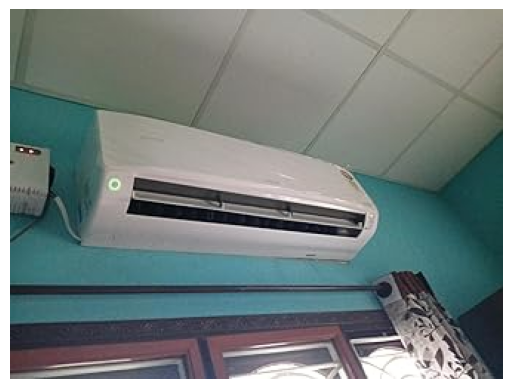

In [12]:
import cv2
import matplotlib.pyplot as plt

# Read the image using OpenCV
image_path = 'AC (26).jpg'  # Path to your image
img = cv2.imread(image_path)

# Check if the image was successfully read
if img is None:
    print(f"Could not read the image at {image_path}. Please check the file path.")
else:
    # Convert from BGR to RGB (OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot the image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [13]:
e='Error'

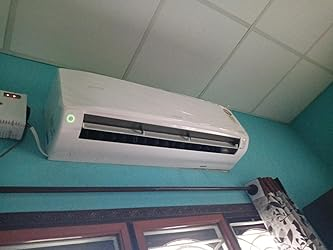

Prediction: AC


In [13]:
import boto3
import cv2
import json
import numpy as np
from IPython.display import display, Image
from io import BytesIO
from PIL import Image as PILImage

# Initialize the SageMaker runtime client
sagemaker_runtime = boto3.client('sagemaker-runtime')

# SageMaker endpoint name
ENDPOINT_NAME = 'sagemaker-tensorflow-serving-2024-11-18-00-17-00-897'

def preprocess_image(image_path):
    """Preprocess the image for prediction."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    normalized_image = resized_image / 255.0
    input_image = np.expand_dims(normalized_image, axis=0)
    return input_image

def predict_image(image_path):
    """Make prediction for the given image using SageMaker endpoint."""
    
    # Display the input image
    display(PILImage.open(image_path))
    
    try:
        # Preprocess the image
        input_image = preprocess_image(image_path)
        
        # Convert image to JSON
        input_data = json.dumps(input_image.tolist())
        
        # Invoke the SageMaker endpoint
        response = sagemaker_runtime.invoke_endpoint(
            EndpointName=ENDPOINT_NAME,
            ContentType="application/json",
            Body=input_data
        )

        # Parse the response
        prediction = json.loads(response['Body'].read().decode())
        predicted_class = np.argmax(prediction)  # Assuming it’s a classification model
        confidence = max(prediction) * 100  # Assuming softmax probabilities
        
        print(f"Prediction: {predicted_class}")
    
    except Exception:
        print(e)

# Usage
predict_image("AC (26).jpg")  # Replace with the path to your image


## Cleanup!

- Stop Notebook
- delete endpoints
- delete models
- delete S3 bucket
- delete cloudwatch groups